# Decision Tree  
## How the Algorithm Works

**The process begins with all examples placed at the root node. Then:**

- **For each available feature, we calculate the information gain and select the one with the highest value.**  
- **We split the dataset based on the selected feature.**  
- **This process repeats recursively until a stopping condition is met.**

---

## Key Concepts

### Entropy  

**Entropy is a measure of impurity or disorder in a dataset.**  

Entropy formula:
$$
H = -\sum p_i \log_2 p_i
$$

Where:
- $p_i$ — the proportion of examples belonging to class $i$ in the node.

---

### Information Gain

**Information gain measures the reduction in entropy after a dataset is split.**  
**We aim to choose the split that results in the highest information gain.**

Formula:
$$
\text{Information Gain} = H(\text{parent}) - \left( w_\text{left} \cdot H(\text{left}) + w_\text{right} \cdot H(\text{right}) \right)
$$

Where:
- $H(\text{parent})$ — entropy of the node before the split  
- $H(\text{left})$, $H(\text{right})$ — entropies of the left and right branches  
- $w_\text{left}$, $w_\text{right}$ — proportions of examples in the left and right branches


In [2]:
import pandas as pd
from pathlib import Path
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
df = pd.read_csv("../data/breast-cancer.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
df.drop('id', axis=1, inplace=True) 

In [9]:
px.pie(df, 'diagnosis', color='diagnosis',title='Data Distribution')

## From this plot we conclude that:
* **Data isn't balanced, accuracy wont be a good evaluation metric for this dataset**

In [10]:
for column in  df.drop('diagnosis',axis=1).columns[:5]:
    fig = px.box(data_frame=df,x='diagnosis',color='diagnosis',y=column,color_discrete_sequence=['#007500','#5CFF5C'],orientation='v')
    fig.show()

In [12]:
for column in  df.drop('diagnosis',axis=1).columns[5:10]:
    fig = px.scatter(data_frame=df,color='diagnosis',x=column,color_discrete_sequence=['#007500','#5CFF5C'],)
    fig.show()

<a id="4"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '

# Data Preprocessing

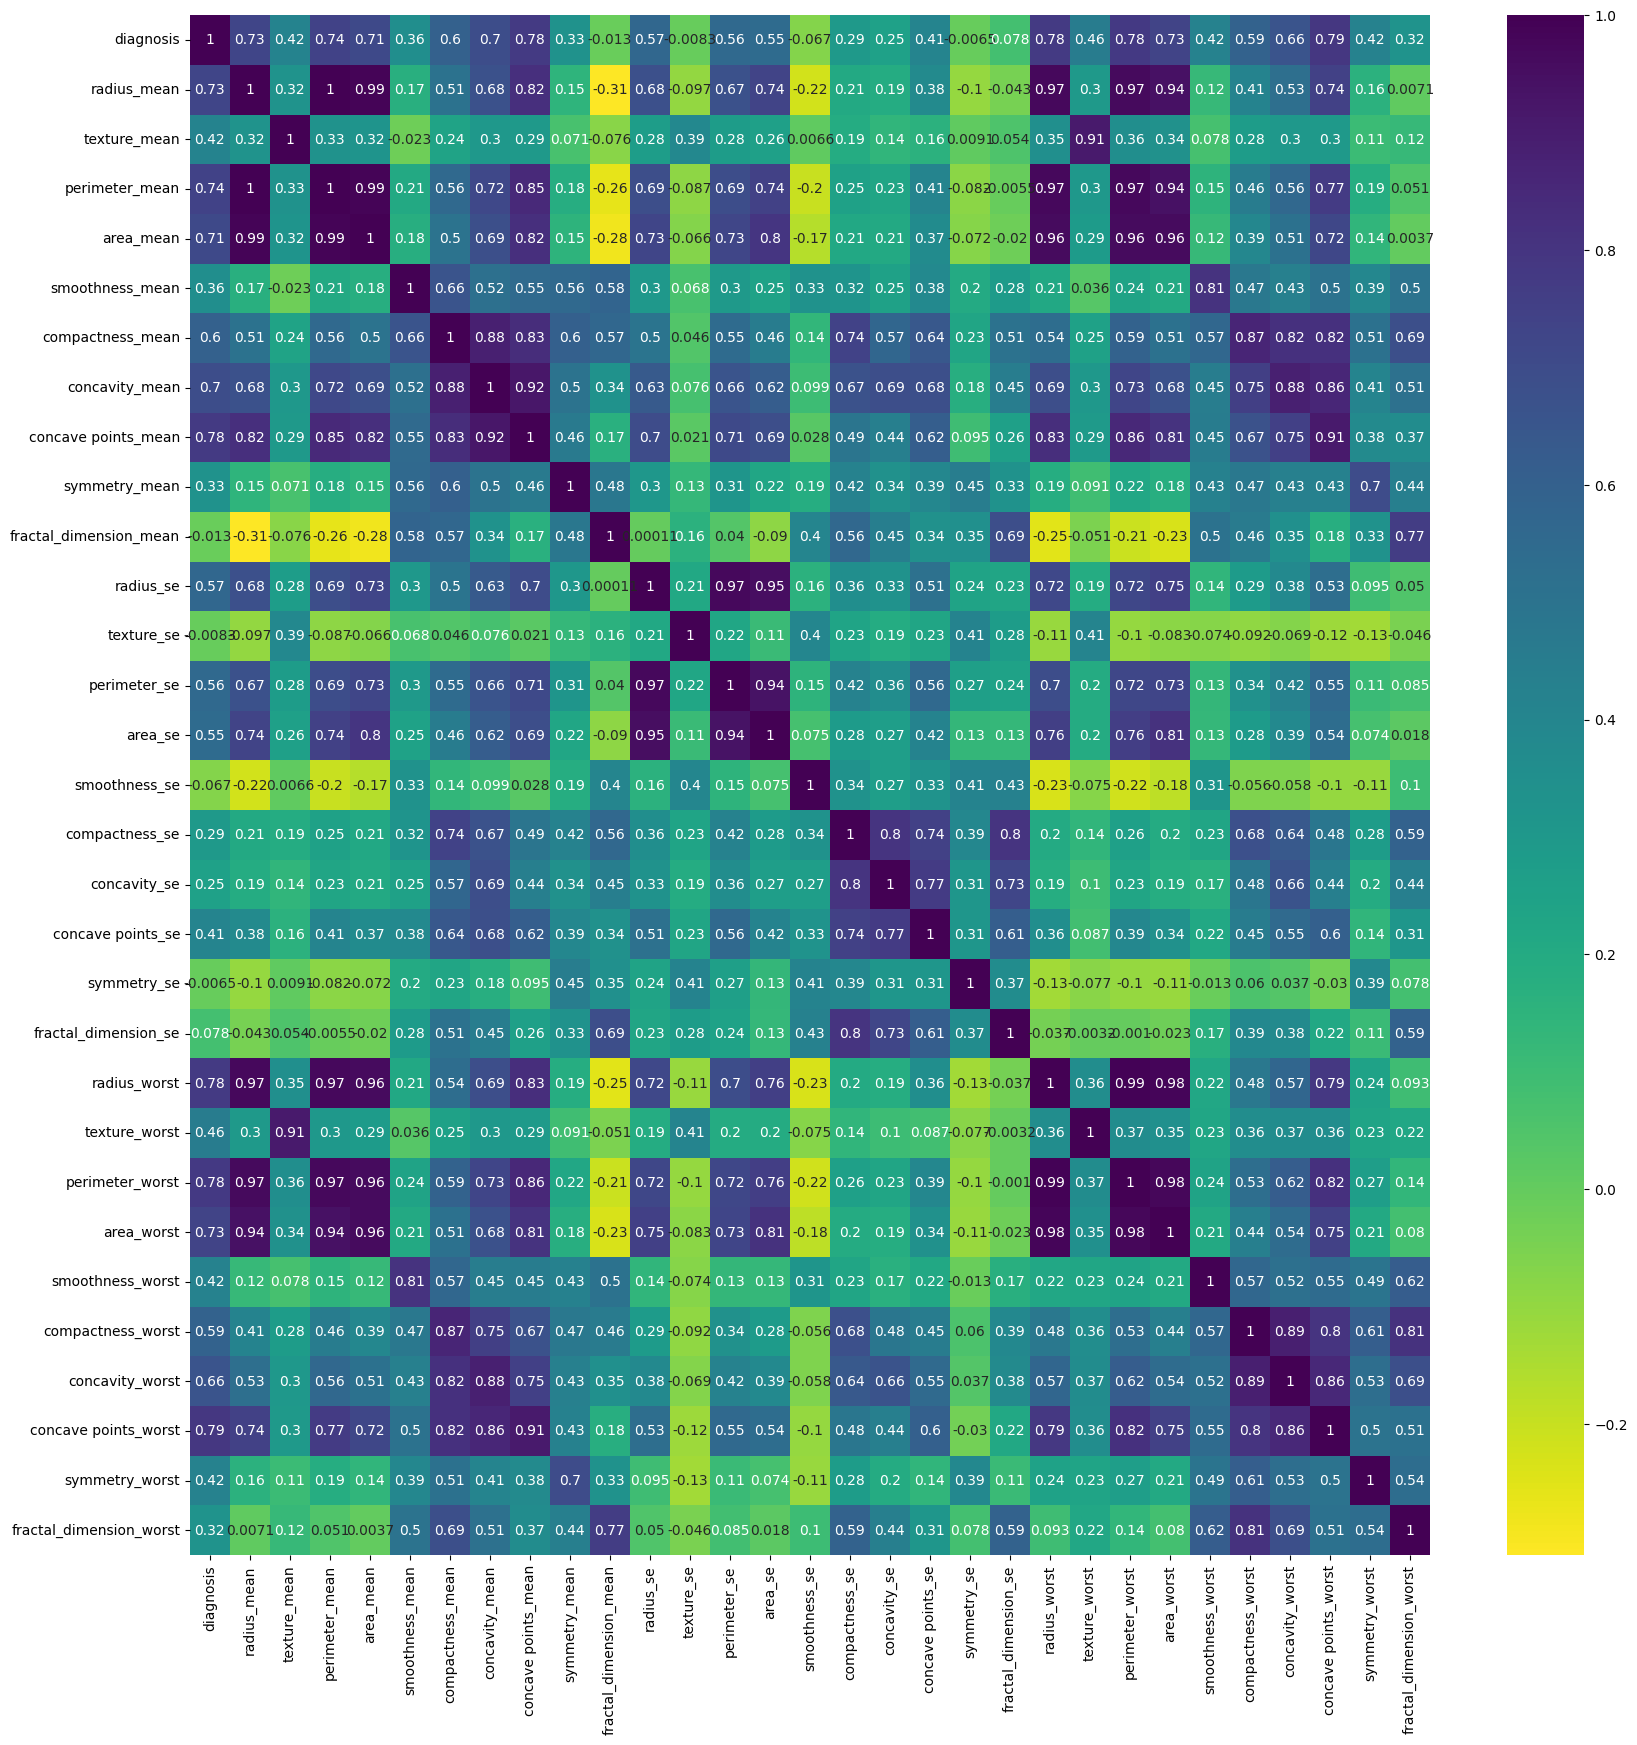

In [5]:
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int)
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='viridis_r',annot=True)
plt.show()

## From this plot we conclude that:
* **Some features aren't correlated with the target maybe we should remove them**

In [6]:
notincluded_columns = abs(corr['diagnosis'])[abs(corr['diagnosis'] < 0.25)]
notincluded_columns = notincluded_columns.index.tolist()
for col in notincluded_columns:
  df.drop(col, axis = 1, inplace = True)

In [7]:
print(notincluded_columns)

['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se']


In [8]:
X = df.drop('diagnosis', axis = 1).values
y = df['diagnosis']
print('Shape of X', X.shape)
print('Shape of y', y.shape)

Shape of X (569, 25)
Shape of y (569,)


In [9]:
from mlfs.preprocessing import  train_test_split, standardize
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = standardize(X_train)
X_test = standardize(X_test)

In [ ]:
from mlfs.decision_tree import DecisionTree as CustomDecisionTree
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree

def benchmark_decision_tree_custom_vs_sklearn(X, y, n_repeats=5):
    """
    Benchmarks training and prediction times for custom and sklearn decision tree implementations.

    Parameters
    ----------
    X : np.ndarray or pd.DataFrame
        Feature matrix.
    y : np.ndarray or pd.Series
        Target vector.
    n_repeats : int
        Number of times to repeat the measurement (for averaging).

    Returns
    -------
    pd.DataFrame
        DataFrame with average fit and predict times for both models.
    """
    import time
    import numpy as np
    import pandas as pd

    custom_fit_times = []
    custom_predict_times = []
    sklearn_fit_times = []
    sklearn_predict_times = []

    for _ in range(n_repeats):
        custom_model = CustomDecisionTree(min_samples=2, max_depth=5)

        start = time.time()
        custom_model.fit(X, y)
        custom_fit_times.append(time.time() - start)

        start = time.time()
        custom_model.predict(X)
        custom_predict_times.append(time.time() - start)

        sklearn_model = SklearnDecisionTree(max_depth=5)

        start = time.time()
        sklearn_model.fit(X, y)
        sklearn_fit_times.append(time.time() - start)

        start = time.time()
        sklearn_model.predict(X)
        sklearn_predict_times.append(time.time() - start)

    results = pd.DataFrame({
        'Model': ['CustomDecisionTree', 'SklearnDecisionTree'],
        'FitTime': [np.mean(custom_fit_times), np.mean(sklearn_fit_times)],
        'PredictTime': [np.mean(custom_predict_times), np.mean(sklearn_predict_times)]
    })

    return results


In [17]:
df_results = benchmark_decision_tree_custom_vs_sklearn(X_train, y_train)
display(df_results)

,Model,FitTime,PredictTime
0,CustomDecisionTree,8.230703,0.000544
1,SklearnDecisionTree,0.007054,0.000207


### Benchmark Results: Custom vs Sklearn Decision Tree


#### Analysis

- **Training Time**: The custom implementation, written from scratch in Python, naturally incurs higher training time compared to scikit-learn’s optimized C-based backend. This trade-off is expected in educational or prototype implementations that prioritize clarity and algorithmic transparency over raw performance.

- **Prediction Time**: While also slightly higher in the custom version, the prediction step remains fast and efficient for typical dataset sizes.

#### Conclusion

This benchmark highlights the performance differences between a reference implementation and a production-grade library. The custom decision tree was developed to deepen understanding of core decision tree logic and data structures, and serves as a solid foundation for future optimization work. Despite the performance gap, the implementation demonstrates correctness and functional parity with sklearn’s API.


Benchmark dla 100 próbek...
Benchmark dla 500 próbek...
Benchmark dla 1000 próbek...
Benchmark dla 5000 próbek...
Benchmark dla 10000 próbek...


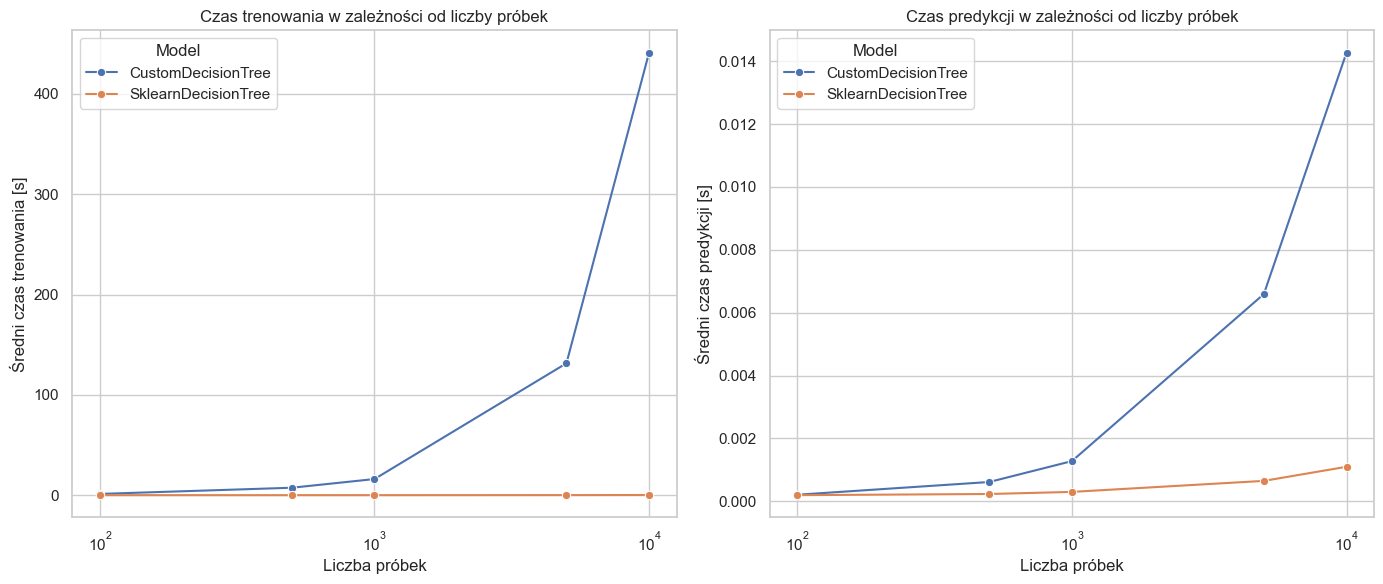

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def benchmark_varying_sample_sizes(sample_sizes, n_features=20, n_classes=2, n_repeats=3):
    all_results = []

    for n_samples in sample_sizes:
        print(f"Benchmarking for {n_samples} samples...")
        X, y = make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_informative=int(n_features * 0.6),
                                   n_redundant=int(n_features * 0.2),
                                   n_classes=n_classes,
                                   random_state=42)
        results = benchmark_decision_tree_custom_vs_sklearn(X, y, n_repeats=n_repeats)
        results['sample_size'] = n_samples
        all_results.append(results)

    df = pd.concat(all_results, ignore_index=True)
    return df

def plot_benchmark_results(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='sample_size', y='FitTime', hue='Model', marker='o')
    plt.title('Training Time vs Number of Samples')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Training Time [s]')
    plt.xscale('log')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='sample_size', y='PredictTime', hue='Model', marker='o')
    plt.title('Prediction Time vs Number of Samples')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Prediction Time [s]')
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

sample_sizes = [100, 500, 1000, 5000, 10000]
df_results = benchmark_varying_sample_sizes(sample_sizes, n_features=20, n_classes=2, n_repeats=3)
plot_benchmark_results(df_results)

In [10]:
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.metrics import balanced_accuracy_score as sklearn_balanced_accuracy_score
from mlfs.metrics import accuracy as custom_accuracy
from mlfs.metrics import balanced_accuracy as custom_balanced_accuracy
import numpy as np
import pandas as pd

def compare_metrics(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    custom_acc = custom_accuracy(y_true, y_pred)
    sklearn_acc = sklearn_accuracy_score(y_true, y_pred)

    custom_bal_acc = custom_balanced_accuracy(y_true, y_pred)
    sklearn_bal_acc = sklearn_balanced_accuracy_score(y_true, y_pred)

    results = pd.DataFrame({
        "Metric": ["Accuracy", "Balanced Accuracy"],
        "Custom": [custom_acc, custom_bal_acc],
        "Sklearn": [sklearn_acc, sklearn_bal_acc]
    })

    return results

In [ ]:
import pandas as pd
from mlfs.decision_tree import DecisionTree as CustomDecisionTree
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree
from mlfs.metrics import (
    accuracy as custom_accuracy,
    balanced_accuracy as custom_balanced_accuracy
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score
)

custom_model = CustomDecisionTree(min_samples=2, max_depth=5)
custom_model.fit(X_train, y_train)

sk_model = SklearnDecisionTree(max_depth=5)
sk_model.fit(X_train, y_train)

y_pred_custom = custom_model.predict(X_test)
y_pred_sk     = sk_model.predict(X_test)

y_true = np.array(y_test).ravel()

acc_c  = custom_accuracy(y_true, y_pred_custom)
balacc_c = custom_balanced_accuracy(y_true, y_pred_custom)

acc_s  = accuracy_score(y_true, y_pred_sk)
balacc_s = balanced_accuracy_score(y_true, y_pred_sk)

df_results = pd.DataFrame({
    'Model':            ['Custom',       'Sklearn'],
    'Accuracy':         [acc_c,          acc_s],
    'Balanced Accuracy':[balacc_c,       balacc_s]
})

display(df_results)


,Model,Accuracy,Balanced Accuracy
0,Custom,0.946903,0.944497
1,Sklearn,0.938053,0.935063
